In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
# For reproducibility
rng = np.random.default_rng(7)

# 1) Data generation
n_per_sample = 500
A = rng.normal(0.0, 1.0, size=n_per_sample)     # Regime A - calm regime
B = rng.normal(0.5, 1.2, size=n_per_sample)     # Regime B (different mean & variance) - shifted mean & higher variance → stressed
C = rng.normal(0.0, 1.0, size=n_per_sample)     # Control: same law as A, different draw

## MMD

In [4]:
# 2) Compute pairwise distances and kernels
def sq_dists(X, Y):
    return (X.reshape(-1,1) - Y.reshape(1,-1))**2

# median heuristic for sigma
Z = np.concatenate([A,B])
D = sq_dists(Z, Z)
sigma_AB = np.median(np.sqrt(D[np.triu_indices_from(D, k=1)]))

Z2 = np.concatenate([A,C])
D2 = sq_dists(Z2, Z2)
sigma_AC = np.median(np.sqrt(D2[np.triu_indices_from(D2, k=1)]))

"""
The RBF kernel needs a bandwidth σ. A strong default is the median of all pairwise distances among the pooled samples.
For A vs B, we pool A and B into Z:
Build all pairwise squared distances D,
Take the upper triangle (in matrix, no duplicates, no zeros on diagonal),
Convert to actual distances with np.sqrt,
Take the median → sigma_AB.
Repeat the same for A vs C to get sigma_AC.
"""

# MMD Formula
def mmd2_biased(X, Y, sigma):
    Kxx = np.exp(-sq_dists(X,X)/(2*sigma*sigma))
    Kyy = np.exp(-sq_dists(Y,Y)/(2*sigma*sigma))
    Kxy = np.exp(-sq_dists(X,Y)/(2*sigma*sigma))
    m, n = len(X), len(Y)
    return (Kxx.sum()/(m*m) + Kyy.sum()/(n*n) - 2*Kxy.sum()/(m*n))


In [5]:
# 3) Compute observed MMDs
mmd_AB = mmd2_biased(A,B,sigma_AB)
mmd_AC = mmd2_biased(A,C,sigma_AC)

# permutation test for p-values
def perm_test(X, Y, sigma, n_perm=1000):
    obs = mmd2_biased(X,Y,sigma)
    Z = np.concatenate([X,Y])
    m = len(X)
    cnt = 0
    for _ in range(n_perm):
        rng.shuffle(Z)
        Xp, Yp = Z[:m], Z[m:]
        if mmd2_biased(Xp,Yp,sigma) >= obs - 1e-15:
            cnt += 1
    return obs, (cnt+1)/(n_perm+1)

"""
Null hypothesis H0: X and Y are from the same distribution.
Procedure:
Pool samples into Z,
Shuffle labels to create surrogate splits (Xp, Yp) under H0​,
Recompute MMD² each time,
p-value ≈ fraction of permuted MMD² ≥ observed MMD² (with add-one smoothing).
If p is small (e.g., < 0.05), we reject H0 → “different distributions”.
"""

obs_AB, p_AB = perm_test(A,B,sigma_AB)
obs_AC, p_AC = perm_test(A,C,sigma_AC)

results = pd.DataFrame({
    "Pair": ["A vs B (different)", "A vs C (same law)"],
    "Sigma": [sigma_AB, sigma_AC],
    "MMD^2": [obs_AB, obs_AC],
    "p-value": [p_AB, p_AC]
})
print(results)

                 Pair     Sigma     MMD^2   p-value
0  A vs B (different)  1.023853  0.069342  0.000999
1   A vs C (same law)  0.955997  0.003844  0.086913


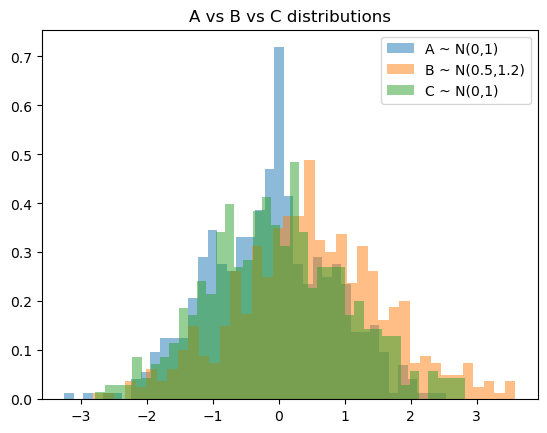

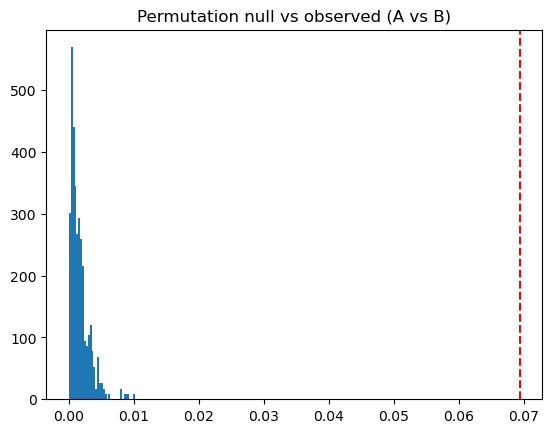

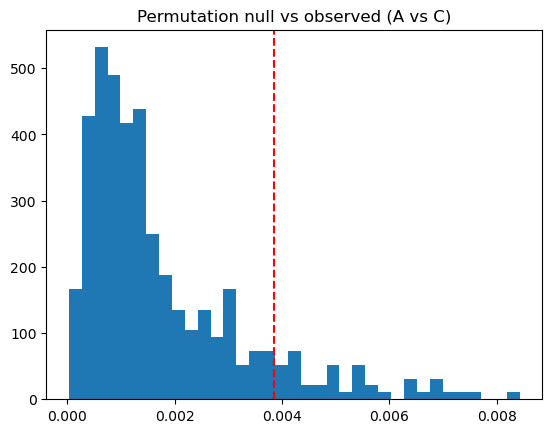

In [6]:
# 4) Plots

# Distributions
plt.hist(A, bins=40, alpha=0.5, density=True, label="A ~ N(0,1)")
plt.hist(B, bins=40, alpha=0.5, density=True, label="B ~ N(0.5,1.2)")
plt.hist(C, bins=40, alpha=0.5, density=True, label="C ~ N(0,1)")
plt.legend(); plt.title("A vs B vs C distributions"); plt.show()

# Permutation null for A vs B
vals = []
Z = np.concatenate([A,B]); m = len(A)
for _ in range(400):
    rng.shuffle(Z)
    Xp, Yp = Z[:m], Z[m:]
    vals.append(mmd2_biased(Xp,Yp,sigma_AB))
plt.hist(vals, bins=35, density=True)
plt.axvline(mmd_AB, color="red", linestyle="--")
plt.title("Permutation null vs observed (A vs B)"); plt.show()

# Permutation null for A vs C
vals = []
Z = np.concatenate([A,C]); m = len(A)
for _ in range(400):
    rng.shuffle(Z)
    Xp, Yp = Z[:m], Z[m:]
    vals.append(mmd2_biased(Xp,Yp,sigma_AC))
plt.hist(vals, bins=35, density=True)
plt.axvline(mmd_AC, color="red", linestyle="--")
plt.title("Permutation null vs observed (A vs C)"); plt.show()

Between-regime (A vs B): high MMD² + small p → distributions differ → good regime separation.

Within-regime (A vs C): low MMD² + large p → distributions same → good within-regime homogeneity.

## Classical Clustering Indexes

- Davies-Bouldin index: Lower is better (measures average similarity between clusters vs. separation).
- Dunn index: Higher is better (measures minimum inter-cluster distance relative to max intra-cluster distance).
- Silhouette coefficient: Range: –1 to 1. Higher means better separation and cohesion.

In [7]:
# Helper to build (X, y) from a dict of clusters -> 1D arrays
def build_xy(cluster_dict):
    labels = sorted(cluster_dict.keys())
    arrays = [cluster_dict[k].reshape(-1,1) for k in labels]
    X = np.vstack(arrays)                           # shape (N,1)
    y = np.concatenate([[i]*len(cluster_dict[lab]) for i, lab in enumerate(labels)])
    return X, y, labels

"""
If A, B, C are returns from 3 periods, each period is treated as a cluster (regime).
build_xy stacks all returns into one dataset (X) and tags each point with a label (y: 0=A, 1=B, 2=C).
"""

# Pairwise distance matrix in 1D (Euclidean)
def pairwise_D(X):
    return np.abs(X - X.T)  # (N,N)

# Metrics
def davies_bouldin(X, y):
    labs = np.unique(y); k = len(labs)
    # centroids & intra-scatter (mean |x - centroid|)
    centroids, S = [], []
    for lab in labs:
        Xi = X[y==lab]
        c  = Xi.mean(axis=0, keepdims=True)
        centroids.append(c)
        S.append(np.mean(np.abs(Xi - c)))
    centroids = np.vstack(centroids)
    # centroid distances
    Cdist = np.abs(centroids - centroids.T)
    # R_ij = (S_i + S_j)/d(c_i,c_j), DB = mean_i max_{j!=i} R_ij
    R = np.full((k,k), -np.inf, float)
    for i in range(k):
        for j in range(k):
            if i != j:
                R[i,j] = (S[i] + S[j]) / (Cdist[i,j] + 1e-12)
    DB = np.mean(np.max(R, axis=1))
    # also return which j caused the max for each i (to illustrate)
    worst_j = np.argmax(R, axis=1)
    return DB, S, centroids, Cdist, worst_j

def dunn_index(D, y):
    labs = np.unique(y); k = len(labs)
    idxs = [np.where(y==lab)[0] for lab in labs]
    # min inter-cluster distance (closest pair of clusters)
    min_inter = np.inf; min_pair = None
    for i in range(k):
        for j in range(i+1,k):
            Dij = D[np.ix_(idxs[i], idxs[j])]
            m = np.min(Dij)
            if m < min_inter:
                min_inter = m; min_pair = (i,j)
    # max intra-cluster diameter (widest cluster)
    max_intra = -np.inf; worst_i = None
    for i in range(k):
        Dii = D[np.ix_(idxs[i], idxs[i])]
        dmax = np.max(Dii)
        if dmax > max_intra:
            max_intra = dmax; worst_i = i
    Dunn = min_inter / (max_intra + 1e-12)
    return Dunn, min_inter, min_pair, max_intra, worst_i

def silhouette_mean(D, y):
    labs = np.unique(y)
    N = len(y)
    a = np.zeros(N)  # mean distance to own cluster
    b = np.zeros(N)  # min mean distance to other cluster(s)
    for i in range(N):
        lab_i = y[i]
        same = np.where(y==lab_i)[0]
        # a(i): mean distance to same-cluster points (exclude self)
        if len(same) > 1:
            a[i] = (D[i, same].sum()) / (len(same) - 1)
        else:
            a[i] = 0.0
        # b(i): min over other clusters of mean distance to that cluster
        means = []
        for lab in labs:
            if lab == lab_i: continue
            idx = np.where(y==lab)[0]
            means.append(np.mean(D[i, idx]))
        b[i] = min(means) if means else 0.0
    s = np.zeros(N)
    for i in range(N):
        denom = max(a[i], b[i])
        s[i] = 0.0 if denom == 0 else (b[i] - a[i]) / denom
    # also provide per-cluster mean silhouette for illustration
    cluster_s = {lab: float(np.mean(s[y==lab])) for lab in labs}
    return float(np.mean(s)), cluster_s

def describe_clusters(X, y, label_names):
    labs = np.unique(y)
    for i, lab in enumerate(labs):
        Xi = X[y==lab].ravel()
        print(f"  Cluster {i} ({label_names[i]}): size={len(Xi)}, mean={Xi.mean():.4f}, std={Xi.std(ddof=1):.4f}")

# THREE-CLUSTER EVALUATION: A | B | C (each its own cluster)
X3, y3, labels3 = build_xy({"A": A, "B": B, "C": C})
D3 = pairwise_D(X3)

print("\n(A) Three clusters: A | B | C")
describe_clusters(X3, y3, labels3)

DB3, S3, C3, Cdist3, worst_j3 = davies_bouldin(X3, y3)
Dunn3, min_inter3, min_pair3, max_intra3, worst_i3 = dunn_index(D3, y3)
Sil3, Sil3_by_cluster = silhouette_mean(D3, y3)

print(f"\nDavies–Bouldin (lower better): {DB3:.6f}")
for i in range(len(labels3)):
    j = worst_j3[i]
    print(f"  - Cluster {i} worst match: vs Cluster {j} "
          f"(scatter S_i={S3[i]:.4f}, S_j={S3[j]:.4f}, centroid dist={Cdist3[i,j]:.4f})")

print(f"\nDunn (higher better): {Dunn3:.6f}")
print(f"  - Closest clusters: {min_pair3} with min inter-cluster distance = {min_inter3:.4f}")
print(f"  - Widest cluster: {worst_i3} with max intra-cluster diameter = {max_intra3:.4f}")

print(f"\nSilhouette mean (−1..1, higher better): {Sil3:.6f}")
for i, lab in enumerate(labels3):
    print(f"  - Cluster {i} ({lab}) mean silhouette: {Sil3_by_cluster[i]:.6f}")



(A) Three clusters: A | B | C
  Cluster 0 (A): size=500, mean=-0.1283, std=0.9379
  Cluster 1 (B): size=500, mean=0.4805, std=1.1319
  Cluster 2 (C): size=500, mean=-0.0228, std=1.0551

Davies–Bouldin (lower better): 11.165011
  - Cluster 0 worst match: vs Cluster 2 (scatter S_i=0.7421, S_j=0.8443, centroid dist=0.1056)
  - Cluster 1 worst match: vs Cluster 2 (scatter S_i=0.8863, S_j=0.8443, centroid dist=0.5033)
  - Cluster 2 worst match: vs Cluster 0 (scatter S_i=0.8443, S_j=0.7421, centroid dist=0.1056)

Dunn (higher better): 0.000000
  - Closest clusters: (1, 2) with min inter-cluster distance = 0.0000
  - Widest cluster: 1 with max intra-cluster diameter = 6.3985

Silhouette mean (−1..1, higher better): -0.043632
  - Cluster 0 (A) mean silhouette: 0.025856
  - Cluster 1 (B) mean silhouette: -0.035107
  - Cluster 2 (C) mean silhouette: -0.121644


In [8]:
# Two clusters: Cluster 0 = A ∪ C (calm), Cluster 1 = B (stressed)
X = np.concatenate([A, B, C]).reshape(-1, 1)              # shape (N,1)
y = np.array([0]*len(A) + [1]*len(B) + [0]*len(C))        # labels (0 or 1)
labels = np.unique(y)
k = len(labels)

# Pairwise distances in 1D (Euclidean)
D = np.abs(X - X.T)   # (N,N)

# Davies–Bouldin index (lower is better)
centroids = []
S = []  # mean intra-cluster distance to centroid
for lab in labels:
    Xi = X[y == lab]                                # (n_i, 1)
    ci = Xi.mean(axis=0, keepdims=True)             # centroid (1,1)
    centroids.append(ci)
    S.append(np.mean(np.abs(Xi - ci)))               # average |x - c|

centroids = np.vstack(centroids)                    # (k,1)
Cdist = np.abs(centroids - centroids.T)             # centroid distances (k,k)

R = np.full((k, k), -np.inf, dtype=float)           # R_ij = (S_i + S_j)/d(c_i,c_j), i!=j
for i in range(k):
    for j in range(k):
        if i != j:
            R[i, j] = (S[i] + S[j]) / (Cdist[i, j] + 1e-12)  # eps to avoid /0

DB_index = np.mean(np.max(R, axis=1))

# Dunn index (higher better)
idxs = [np.where(y == lab)[0] for lab in labels]

# min inter-cluster distance between any two points from different clusters
min_inter = np.inf
for i in range(k):
    for j in range(i+1, k):
        Dij = D[np.ix_(idxs[i], idxs[j])]
        min_inter = min(min_inter, np.min(Dij))

# max intra-cluster diameter (max pairwise distance inside any cluster)
max_intra = -np.inf
for i in range(k):
    Dii = D[np.ix_(idxs[i], idxs[i])]
    max_intra = max(max_intra, np.max(Dii))

Dunn_index = min_inter / (max_intra + 1e-12)

# Silhouette coefficient (higher better)
N = len(X)
a = np.zeros(N)  # mean distance to own cluster
b = np.zeros(N)  # min mean distance to other cluster(s)

for i in range(N):
    lab_i = y[i]
    same_idx = np.where(y == lab_i)[0]
    # a(i): average distance to same-cluster points (exclude self)
    if len(same_idx) > 1:
        a[i] = (D[i, same_idx].sum() - 0.0) / (len(same_idx) - 1)  # self-distance is 0
    else:
        a[i] = 0.0

    # b(i): min over other clusters of mean distance to that cluster
    means = []
    for lab in labels:
        if lab == lab_i:
            continue
        idx = np.where(y == lab)[0]
        means.append(np.mean(D[i, idx]))
    b[i] = min(means) if means else 0.0

s = np.zeros(N)
for i in range(N):
    denom = max(a[i], b[i])
    s[i] = 0.0 if denom == 0 else (b[i] - a[i]) / denom

Silhouette_mean = np.mean(s)

print("Cluster Quality Metrics (2 clusters: (A ∪ C) vs B)")
print(f"Davies–Bouldin (lower is better): {DB_index:.6f}")
print(f"Dunn (higher is better)         : {Dunn_index:.6f}")
print(f"Silhouette (−1..1, higher better): {Silhouette_mean:.6f}")

for lab in labels:
    Xi = X[y==lab]
    print(f"Cluster {lab}: size={len(Xi)}, mean={Xi.mean():.4f}, std={Xi.std(ddof=1):.4f}")

Cluster Quality Metrics (2 clusters: (A ∪ C) vs B)
Davies–Bouldin (lower is better): 3.019845
Dunn (higher is better)         : 0.000000
Silhouette (−1..1, higher better): 0.069742
Cluster 0: size=1000, mean=-0.0755, std=0.9991
Cluster 1: size=500, mean=0.4805, std=1.1319
